In [1]:
import pandas as pd
import numpy as np
import polars as pl
import statsmodels.api as sm
import requests, zipfile, io
import calendar
from linearmodels import PanelOLS
from pandas.tseries.offsets import MonthEnd, YearEnd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [2]:
df_forecasts = pl.read_parquet("full_results/composite_forecasts.parquet")
df_fundamental = pl.read_parquet("data/monthly_dataset.parquet")

Not enough gvkey data for 2024 yet

In [3]:
df_forecasts = df_forecasts.with_columns(
    pl.col("gvkey").cast(pl.Int64).cast(pl.Utf8).str.zfill(6)
)
df_fundamental = df_fundamental.with_columns(
    pl.col("gvkey").cast(pl.Int64).cast(pl.Utf8).str.zfill(6),
    pl.col("date").cast(pl.Date),
    pl.col("retadj_x").alias("retadj")
)
df_fundamental_subset = df_fundamental.select(["gvkey", "date", "sic", "retadj"])
# Drop 2024 data
df_fundamental_subset = df_fundamental_subset.filter(pl.col("date").dt.year() != 2024)

In [4]:
df_calendar = (
    df_fundamental_subset.select(
        pl.col("date"),
        pl.col("date").dt.year().alias("year"),
        pl.col("date").dt.month().alias("month")
    )
    .unique()
    .group_by(["year", "month"])
    .agg(pl.col("date").max().alias("date"))
    .sort(["year", "month"])
    .select(["year", "date"])
)

In [5]:
df_forecasts = df_forecasts.with_columns(
    pl.col("year").cast(pl.Int32)
)

df_calendar = df_calendar.with_columns(
    pl.col("year").cast(pl.Int32)
)

df_forecasts_monthly = df_forecasts.join(
    df_calendar, on="year", how="inner"
)

In [6]:
df_merged = df_forecasts_monthly.join(
    df_fundamental_subset, on=["date", "gvkey"], how="inner"
)

In [7]:
# drop missing retadj values
df_merged = df_merged.drop_nulls()
print("Number of missing retadj values: ", df_merged.filter(pl.col("retadj").is_null()).shape[0])

Number of missing retadj values:  0


In [8]:
null_counts = df_merged.null_count()
print(null_counts)

shape: (1, 39)
┌───────┬──────┬─────┬─────────┬───┬───────────────────────┬──────┬─────┬────────┐
│ gvkey ┆ year ┆ E   ┆ mkt_cap ┆ … ┆ abs_error_rw_baseline ┆ date ┆ sic ┆ retadj │
│ ---   ┆ ---  ┆ --- ┆ ---     ┆   ┆ ---                   ┆ ---  ┆ --- ┆ ---    │
│ u32   ┆ u32  ┆ u32 ┆ u32     ┆   ┆ u32                   ┆ u32  ┆ u32 ┆ u32    │
╞═══════╪══════╪═════╪═════════╪═══╪═══════════════════════╪══════╪═════╪════════╡
│ 0     ┆ 0    ┆ 0   ┆ 0       ┆ … ┆ 0                     ┆ 0    ┆ 0   ┆ 0      │
└───────┴──────┴─────┴─────────┴───┴───────────────────────┴──────┴─────┴────────┘


In [9]:
cols_to_keep = ['gvkey', 'year', 'E', 'mkt_cap', 'E_future', 'E_pred_ols', 'E_pred_ann_bagging', 'E_pred_ar', 'E_pred_catboost', 'E_pred_gbf', 
                'E_pred_hvz', 'E_pred_lasso', 'E_pred_lightgbm', 'E_pred_ri', 'E_pred_ridge', 'E_pred_rw', 'E_pred_xgb', 'COMP_EXT', 'COMP_LR', 
                'COMP_NL', 'COMP_ML', 'COMP_MED_EXT', 'COMP_MED_LR', 'COMP_MED_NL', 'COMP_MED_ML', 'date', 'sic', 'retadj']
df_merged = df_merged.select(cols_to_keep)

In [10]:
# Keep only unique gvkey-date pairs
df_merged = df_merged.unique(subset=["gvkey", "date"])

In [11]:
# Check for NaN values in df_merged
null_counts = df_merged.null_count()
print(null_counts)

shape: (1, 28)
┌───────┬──────┬─────┬─────────┬───┬─────────────┬──────┬─────┬────────┐
│ gvkey ┆ year ┆ E   ┆ mkt_cap ┆ … ┆ COMP_MED_ML ┆ date ┆ sic ┆ retadj │
│ ---   ┆ ---  ┆ --- ┆ ---     ┆   ┆ ---         ┆ ---  ┆ --- ┆ ---    │
│ u32   ┆ u32  ┆ u32 ┆ u32     ┆   ┆ u32         ┆ u32  ┆ u32 ┆ u32    │
╞═══════╪══════╪═════╪═════════╪═══╪═════════════╪══════╪═════╪════════╡
│ 0     ┆ 0    ┆ 0   ┆ 0       ┆ … ┆ 0           ┆ 0    ┆ 0   ┆ 0      │
└───────┴──────┴─────┴─────────┴───┴─────────────┴──────┴─────┴────────┘


In [51]:
# -----------------------------
# Step 1. For each month, estimate the new information component.
# -----------------------------
def compute_resid_info(subdf: pl.DataFrame) -> pl.DataFrame:
    X = subdf.select(["E_pred_rw", "COMP_EXT"]).to_pandas()
    y = subdf.select("COMP_ML").to_pandas().squeeze()
    X = sm.add_constant(X) 
    model = sm.OLS(y, X).fit()
    residuals = model.resid.values
    return subdf.with_columns(pl.Series("ML_resid", residuals))

In [52]:
dfs = []
for date_val, group_df in df_merged.group_by("date"):
    dfs.append(compute_resid_info(group_df))
df_merged = pl.concat(dfs)

In [53]:
# ---------------------------------------------------------------------
# Step 2. Assign stocks into quintiles based on new information
#         within each three-digit SIC group for each month.
# ---------------------------------------------------------------------
df_merged = df_merged.with_columns(
    pl.col("sic")
      .cast(pl.Utf8)
      .str.slice(0, 3)
      .alias("sic_3d")
)

bounds = (
    df_merged
    .group_by(["date", "sic_3d"])
    .agg([
        pl.col("ML_resid").quantile(0.2).alias("q20"),
        pl.col("ML_resid").quantile(0.4).alias("q40"),
        pl.col("ML_resid").quantile(0.6).alias("q60"),
        pl.col("ML_resid").quantile(0.8).alias("q80")
    ])
)

df_merged = df_merged.join(bounds, on=["date", "sic_3d"], how="left")

df_merged = df_merged.with_columns(
    pl.when(pl.col("ML_resid") <= pl.col("q20"))
      .then(1)
      .when(pl.col("ML_resid") <= pl.col("q40"))
      .then(2)
      .when(pl.col("ML_resid") <= pl.col("q60"))
      .then(3)
      .when(pl.col("ML_resid") <= pl.col("q80"))
      .then(4)
      .otherwise(5)
      .alias("quintile")
)

In [54]:
# ---------------------------------------------------------------------
# Step 3. Construct hedge portfolios.
#
# For each month, we compute:
#   - Equal-weighted return (ret_ew) as the simple average of retadj.
#   - Value-weighted return (ret_vw) as the weighted average using mkt_cap.
#
# Then, for each month, we extract returns for quintile 1 (least favorable new info)
# and quintile 5 (most favorable new info) and compute the hedge portfolio return as:
#   Hedge Return = Return (Q5) - Return (Q1)
# ---------------------------------------------------------------------
# Compute returns within each (date, quintile) group.
df_portfolio_agg = df_merged.group_by(["date", "quintile"]).agg([
    pl.col("retadj").mean().alias("ret_ew"),
    ((pl.col("retadj") * pl.col("mkt_cap")).sum() / pl.col("mkt_cap").sum()).alias("ret_vw")
])

# Extract quintile 1 and quintile 5 returns.
df_q1 = df_portfolio_agg.filter(pl.col("quintile") == 1) \
        .select(["date", "ret_ew", "ret_vw"]) \
        .rename({"ret_ew": "ret_ew_1", "ret_vw": "ret_vw_1"})
df_q5 = df_portfolio_agg.filter(pl.col("quintile") == 5) \
        .select(["date", "ret_ew", "ret_vw"]) \
        .rename({"ret_ew": "ret_ew_5", "ret_vw": "ret_vw_5"})


df_portfolio = df_q1.join(df_q5, on="date", how="full")

# Compute hedge portfolio returns.
df_portfolio = df_portfolio.with_columns([
    (pl.col("ret_ew_5") - pl.col("ret_ew_1")).alias("hedge_ret_ew"),
    (pl.col("ret_vw_5") - pl.col("ret_vw_1")).alias("hedge_ret_vw")
])


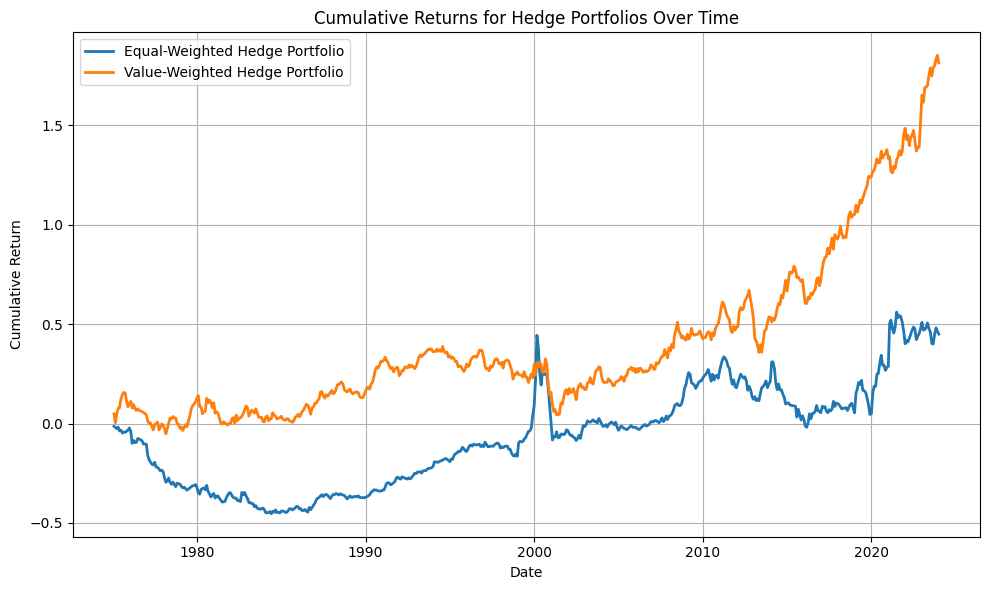

In [55]:
# Sort the DataFrame by date
df_portfolio = df_portfolio.sort("date")

# Compute cumulative returns using NumPy's cumprod on the underlying array
cum_ret_ew = np.cumprod(df_portfolio["hedge_ret_ew"].to_numpy() + 1) - 1
cum_ret_vw = np.cumprod(df_portfolio["hedge_ret_vw"].to_numpy() + 1) - 1

# Add the computed cumulative returns as new columns
df_portfolio = df_portfolio.with_columns([
    pl.Series("cum_ret_ew", cum_ret_ew),
    pl.Series("cum_ret_vw", cum_ret_vw)
])

# Convert to pandas DataFrame for plotting
df_portfolio_pd = df_portfolio.to_pandas()
df_portfolio_pd['date'] = pd.to_datetime(df_portfolio_pd['date'])

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(df_portfolio_pd['date'], df_portfolio_pd['cum_ret_ew'], label='Equal-Weighted Hedge Portfolio', linewidth=2)
plt.plot(df_portfolio_pd['date'], df_portfolio_pd['cum_ret_vw'], label='Value-Weighted Hedge Portfolio', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns for Hedge Portfolios Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# Annualized Mean Returns of the hedge portfolios
annualized_mean_ret_ew = 12 * df_portfolio_pd['hedge_ret_ew'].mean()
annualized_mean_ret_vw = 12 * df_portfolio_pd['hedge_ret_vw'].mean()
print(f"Annualized Mean Return (Equal-Weighted Hedge Portfolio): {annualized_mean_ret_ew:.2%}")
print(f"Annualized Mean Return (Value-Weighted Hedge Portfolio): {annualized_mean_ret_vw:.2%}")

Annualized Mean Return (Equal-Weighted Hedge Portfolio): 1.08%
Annualized Mean Return (Value-Weighted Hedge Portfolio): 2.32%


In [57]:
# Max Drawdown of the hedge portfolios and the time period
def compute_max_drawdown(cum_returns):
    growth = cum_returns + 1
    running_max = np.maximum.accumulate(growth)
    drawdown = growth / running_max - 1
    return drawdown.min()
max_dd_ew = compute_max_drawdown(cum_ret_ew)
max_dd_vw = compute_max_drawdown(cum_ret_vw)

print("Max Drawdown (Equal-weighted):", max_dd_ew)
print("Max Drawdown (Value-weighted):", max_dd_vw)

Max Drawdown (Equal-weighted): -0.44632660930893686
Max Drawdown (Value-weighted): -0.24770667876328778


In [58]:
# Calculate the annualized sharpe ratio of the hedge portfolios
annualized_sharpe_ew = np.sqrt(12) * df_portfolio_pd['hedge_ret_ew'].mean() / df_portfolio_pd['hedge_ret_ew'].std()
annualized_sharpe_vw = np.sqrt(12) * df_portfolio_pd['hedge_ret_vw'].mean() / df_portfolio_pd['hedge_ret_vw'].std()
print(f"Annualized Sharpe Ratio (Equal-Weighted): {annualized_sharpe_ew:.4f}")
print(f"Annualized Sharpe Ratio (Value-Weighted): {annualized_sharpe_vw:.4f}")

Annualized Sharpe Ratio (Equal-Weighted): 0.1335
Annualized Sharpe Ratio (Value-Weighted): 0.3648


In [59]:
def load_ff3_factors_local(filepath="F-F_Research_Data_Factors.CSV"):
    """
    Loads and processes the Fama-French 3-factor file (plus RF) 
    """
    df = pd.read_csv(filepath, skiprows=3)
    
    df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    
    df = df[df["Date"].astype(str).str.match(r'^\d{6}$')]
    
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m")
    
    for col in ["Mkt-RF", "SMB", "HML", "RF"]:
        df[col] = pd.to_numeric(df[col], errors="coerce") / 100
    
    df.rename(columns={"Mkt-RF": "Mkt_RF"}, inplace=True)
    
    return df

def load_ff5_factors_local(filepath="F-F_Research_Data_5_Factors_2x3.CSV"):
    """
    Loads and processes the Fama-French 5-factor file (plus RF).
    """
    df = pd.read_csv(filepath, skiprows=3)
    
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    
    df = df[df["Date"].astype(str).str.match(r'^\d{6}$')]
    
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m")
    
    df.rename(columns={"Mkt-RF": "Mkt_RF"}, inplace=True)
    
    factor_cols = ["Mkt_RF", "SMB", "HML", "RMW", "CMA", "RF"]
    for col in factor_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce") / 100 
    
    return df

def load_momentum_factor_local(filepath="F-F_Momentum_Factor.CSV"):
    """
    Loads and processes the Momentum factor file.
    """
    df = pd.read_csv(filepath, skiprows=13)

    df.columns = df.columns.str.strip()
    
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    
    df = df[df["Date"].astype(str).str.match(r'^\d{6}$')]
    
    df["Date"] = pd.to_datetime(df["Date"], format="%Y%m")
    
    df["Mom"] = pd.to_numeric(df["Mom"], errors="coerce") / 100
    
    return df

In [60]:
df_ff3 = load_ff3_factors_local("data/F-F_Research_Data_Factors.CSV")
ff5_df = load_ff5_factors_local("data/F-F_Research_Data_5_Factors_2x3.CSV")
mom_df = load_momentum_factor_local("data/F-F_Momentum_Factor.CSV")

In [61]:
df_ff3_pl = pl.from_pandas(df_ff3)
df_portfolio = df_portfolio.with_columns(pl.col("date").cast(pl.Datetime("ns")))
df_portfolio = df_portfolio.with_columns(
    pl.col("date").dt.truncate("1mo")
)
df_merged_ff3 = df_portfolio.join(df_ff3_pl, left_on="date", right_on="Date", how="inner")
df_merged_ff3 = df_merged_ff3.with_columns(
    (pl.col("hedge_ret_vw") - pl.col("RF")).alias("excess_ret_vw"),
    (pl.col("hedge_ret_ew") - pl.col("RF")).alias("excess_ret_ew")
)

In [62]:
mom_pl = pl.from_pandas(mom_df)
df_carhart = df_ff3_pl.join(mom_pl, on="Date", how="inner")
df_reg_carhart = df_portfolio.join(df_carhart, left_on="date", right_on="Date", how="inner")
df_reg_carhart = df_reg_carhart.with_columns(
    (pl.col("hedge_ret_vw") - pl.col("RF")).alias("excess_ret_vw"),
    (pl.col("hedge_ret_ew") - pl.col("RF")).alias("excess_ret_ew")
)

In [63]:
df_ff5_pl = pl.from_pandas(ff5_df)
df_merged_ff5 = df_portfolio.join(df_ff5_pl, left_on="date", right_on="Date", how="inner")
df_merged_ff5 = df_merged_ff5.with_columns(
    (pl.col("hedge_ret_vw") - pl.col("RF")).alias("excess_ret_vw"),
    (pl.col("hedge_ret_ew") - pl.col("RF")).alias("excess_ret_ew")
)

In [64]:
def calc_alpha(df, factor_list, ret_col):
    X = df.select(factor_list).to_pandas()
    X = sm.add_constant(X) 
    y = df.select(ret_col).to_pandas().squeeze() 
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
    return model.params["const"], model

In [65]:
# Value weighted CAPM alpha
alpha_vw, model_vw = calc_alpha(df_merged_ff3, ["Mkt_RF"], "excess_ret_vw")
print("Value-Weighted CAPM Alpha:", alpha_vw)
print(model_vw.summary())

Value-Weighted CAPM Alpha: -0.002030881420883425
                            OLS Regression Results                            
Dep. Variable:          excess_ret_vw   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     11.53
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           0.000731
Time:                        08:41:41   Log-Likelihood:                 1512.2
No. Observations:                 588   AIC:                            -3020.
Df Residuals:                     586   BIC:                            -3012.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [66]:
# Equal weighted CAPM alpha
alpha_ew, model_ew = calc_alpha(df_merged_ff3, ["Mkt_RF"], "excess_ret_ew")
print("Equal-Weighted CAPM Alpha:", alpha_ew)
print(model_ew.summary())

Equal-Weighted CAPM Alpha: -0.0030970343747520833
                            OLS Regression Results                            
Dep. Variable:          excess_ret_ew   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.980
Date:                Tue, 11 Mar 2025   Prob (F-statistic):            0.00846
Time:                        08:41:41   Log-Likelihood:                 1373.8
No. Observations:                 588   AIC:                            -2744.
Df Residuals:                     586   BIC:                            -2735.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [67]:
# Value weighted FF3 alpha
alpha_vw_ff3, model_vw_ff3 = calc_alpha(df_merged_ff3, ["Mkt_RF", "SMB", "HML"], "excess_ret_vw")
print("Value-Weighted FF3 Alpha:", alpha_vw_ff3)
print(model_vw_ff3.summary())

Value-Weighted FF3 Alpha: -0.001783816899788942
                            OLS Regression Results                            
Dep. Variable:          excess_ret_vw   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.972
Date:                Tue, 11 Mar 2025   Prob (F-statistic):            0.00205
Time:                        08:41:41   Log-Likelihood:                 1516.6
No. Observations:                 588   AIC:                            -3025.
Df Residuals:                     584   BIC:                            -3008.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons

In [68]:
# Equal weighted FF3 alpha
alpha_ew_ff3, model_ew_ff3 = calc_alpha(df_merged_ff3, ["Mkt_RF", "SMB", "HML"], "excess_ret_ew")
print("Equal-Weighted FF3 Alpha:", alpha_ew_ff3)
print(model_ew_ff3.summary())

Equal-Weighted FF3 Alpha: -0.0025479679321875484
                            OLS Regression Results                            
Dep. Variable:          excess_ret_ew   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     6.748
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           0.000176
Time:                        08:41:41   Log-Likelihood:                 1397.3
No. Observations:                 588   AIC:                            -2787.
Df Residuals:                     584   BIC:                            -2769.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [69]:
# Value weighted Carhart alpha
alpha_vw_carhart, model_vw_carhart = calc_alpha(df_reg_carhart, ["Mkt_RF", "SMB", "HML", "Mom"], "excess_ret_vw")
print("Value-Weighted Carhart Alpha:", alpha_vw_carhart)
print(model_vw_carhart.summary())

Value-Weighted Carhart Alpha: -0.002102085389331161
                            OLS Regression Results                            
Dep. Variable:          excess_ret_vw   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.861
Date:                Tue, 11 Mar 2025   Prob (F-statistic):            0.00418
Time:                        08:41:41   Log-Likelihood:                 1519.3
No. Observations:                 588   AIC:                            -3029.
Df Residuals:                     583   BIC:                            -3007.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


In [70]:
# Equal weighted Carhart alpha
alpha_ew_carhart, model_ew_carhart = calc_alpha(df_reg_carhart, ["Mkt_RF", "SMB", "HML", "Mom"], "excess_ret_ew")
print("Equal-Weighted Carhart Alpha:", alpha_ew_carhart)
print(model_ew_carhart.summary())

Equal-Weighted Carhart Alpha: -0.003066075599987973
                            OLS Regression Results                            
Dep. Variable:          excess_ret_ew   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.643
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           0.000184
Time:                        08:41:41   Log-Likelihood:                 1402.0
No. Observations:                 588   AIC:                            -2794.
Df Residuals:                     583   BIC:                            -2772.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


In [71]:
# Value weighted FF5 alpha
alpha_vw_ff5, model_vw_ff5 = calc_alpha(df_merged_ff5, ["Mkt_RF", "SMB", "HML", "RMW", "CMA"], "excess_ret_vw")
print("Value-Weighted FF5 Alpha:", alpha_vw_ff5)
print(model_vw_ff5.summary())

Value-Weighted FF5 Alpha: -0.0018638282898693563
                            OLS Regression Results                            
Dep. Variable:          excess_ret_vw   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.803
Date:                Tue, 11 Mar 2025   Prob (F-statistic):            0.00213
Time:                        08:41:41   Log-Likelihood:                 1516.7
No. Observations:                 588   AIC:                            -3021.
Df Residuals:                     582   BIC:                            -2995.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [72]:
# Equal weighted FF5 alpha
alpha_ew_ff5, model_ew_ff5 = calc_alpha(df_merged_ff5, ["Mkt_RF", "SMB", "HML", "RMW", "CMA"], "excess_ret_ew")
print("Equal-Weighted FF5 Alpha:", alpha_ew_ff5)
print(model_ew_ff5.summary())

Equal-Weighted FF5 Alpha: -0.0017460626834714052
                            OLS Regression Results                            
Dep. Variable:          excess_ret_ew   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     7.100
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           1.85e-06
Time:                        08:41:41   Log-Likelihood:                 1424.5
No. Observations:                 588   AIC:                            -2837.
Df Residuals:                     582   BIC:                            -2811.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [77]:
# Read the full results
df_full_results = pl.read_parquet("full_results/portfolio_analysis_results.parquet")

In [78]:
df_full_results.write_json("full_results/portfolio_analysis_results.json")


In [3]:
df_direct_sort = pl.read_parquet("full_results/portfolio_analysis_direct_sort.parquet")
df_direct_sort.write_json("full_results/portfolio_analysis_direct_sort.json")